# Задание 3.

Загрузите [данные по изменению температуры поверхности земли](https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data). Для этого может понадобится зарегистрироваться на [Kaggle](https://kaggle.com). Затем нужно будет работать с данными, которые содержатся в файле **GlobalLandTemperaturesByMajorCity.csv**

In [1]:
import zipfile

import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

with zipfile.ZipFile("archive.zip") as z:
    with z.open("GlobalLandTemperaturesByMajorCity.csv") as f:
        df = pd.read_csv(f, parse_dates=["dt"])

df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W


# Задание 3.1 (1 балл)

В последующих заданиях будут учитываться данные начиная с 01.01.1950. Для этого создайте новый `DataFrame`, в котором удалены все строки до 01.01.1950. Используйте созданный DataFrame в последующих заданиях.  

In [2]:
df = df[df["dt"] >= "1950-01-01"]
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
1212,1950-01-01,26.773,0.239,Abidjan,Côte D'Ivoire,5.63N,3.23W
1213,1950-02-01,27.527,0.348,Abidjan,Côte D'Ivoire,5.63N,3.23W
1214,1950-03-01,28.344,0.431,Abidjan,Côte D'Ivoire,5.63N,3.23W
1215,1950-04-01,27.830,0.467,Abidjan,Côte D'Ivoire,5.63N,3.23W
1216,1950-05-01,26.896,0.248,Abidjan,Côte D'Ivoire,5.63N,3.23W


# Задание 3.2 (2 балла)

Постройте график среднегодовых температур в городе Торонто.

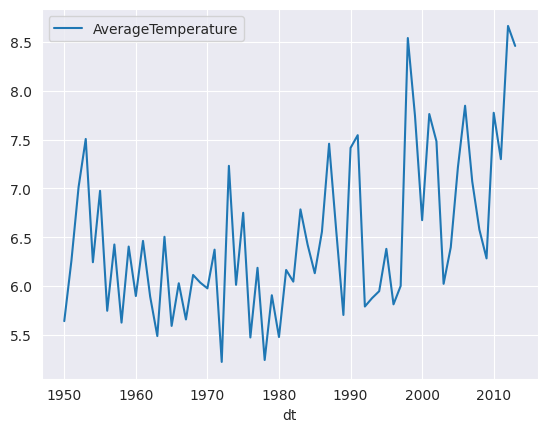

In [3]:
toronto_data = df.loc[df["City"] == "Toronto"].copy()
# .to_frame() because Series plot does not have a legend, but I want it to
mean_tmp = toronto_data.groupby(toronto_data['dt'].dt.year)['AverageTemperature'].mean().to_frame().plot()

# Задание 3.3 (2 балла)

Найдите город, для которого выборочная дисперсия температур на приведенных данных максимальна. 

In [4]:
df.groupby("City")["AverageTemperature"].var().idxmax()

'Harbin'

# Задание 3.4 (4 балла)

На одной оси постройте графики, отображающие:
1. Зависимость выборочной дисперсии температур от широты города (Latitude).
2. Зависимость средней температуры в январе 1975 года от широты города (Latitude).
3. Зависимость средней температуры в июле 1975 года от широты города (Latitude).

<Axes: xlabel='Latitude'>

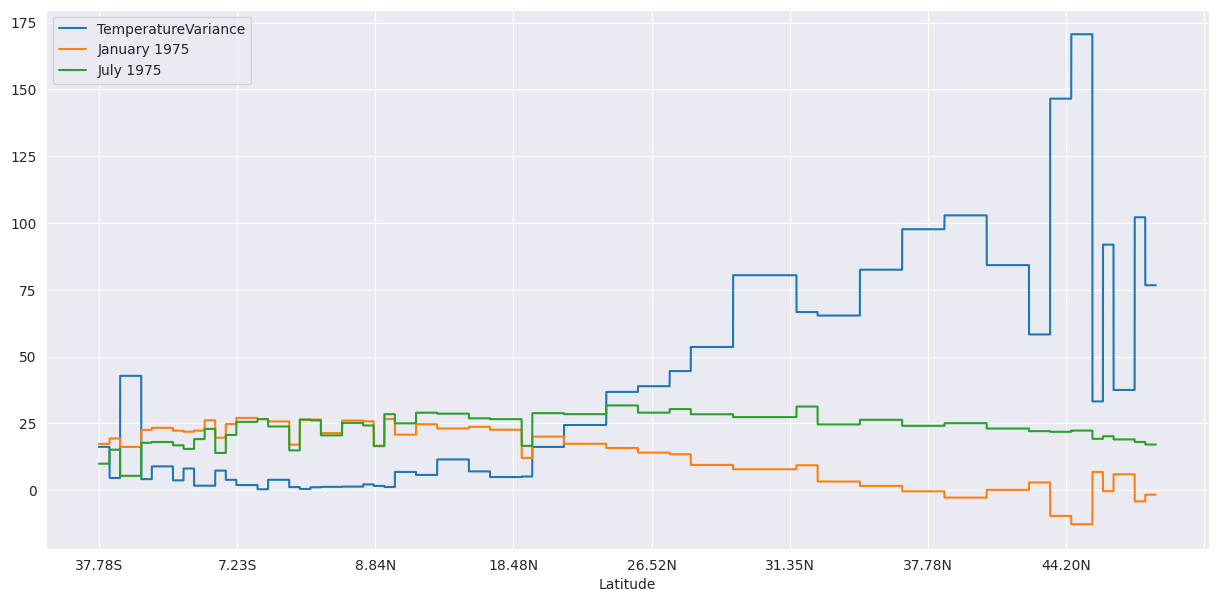

In [5]:
# calc all aggregations
temperature_variance = df.groupby("Latitude")["AverageTemperature"].var().rename("TemperatureVariance")
january_1975 = df[df["dt"] == "1975-01-01"].groupby("Latitude")["AverageTemperature"].mean().rename("January 1975")
july_1975 = df[df["dt"] == "1975-07-01"].groupby("Latitude")["AverageTemperature"].mean().rename("July 1975")

# I don't know how good of an idea it is, but I felt like the task was hinting at necessity of using plot on pandas df and not just regular matplotlib shenanigans
# Therefore I merged all the data into one df
merged_df = pd.merge(df["Latitude"], temperature_variance, on="Latitude").merge(january_1975, on="Latitude").merge(july_1975, on="Latitude")

# Latitude is a string with S or N at the end, so It's probably a good idea to convert it to float for the sake of displaying in the right order
# Might be a good idea to write some custom sorting for Latitude, but it looked too much of a crutch to me
merged_df['FloatLatitude'] = merged_df.Latitude.apply(lambda x: -float(x.strip('S')) if x.endswith('S') else float(x.strip('N')))
merged_df = merged_df.sort_values(by="FloatLatitude")

merged_df[["TemperatureVariance", "January 1975", "July 1975", "Latitude"]].plot(x="Latitude", figsize=(15, 7))
# import matplotlib.pyplot as plt

# plt.plot(temperature_variance, label="TemperatureVariance")
# plt.plot(january_1975, label="January 1975")
# plt.plot(july_1975, label="July 1975")
# plt.legend()
# plt.show()

# Задание 3.5 (6 баллов)

Посчитайте данные по среднегодовой температуре в Санкт-Петербурге. Определите года, в которых средняя температура была выше, чем в предыдущем  и последующем году. Постройте график среднегодовой температуры и обозначьте на нём найденные года (произвольным образом). 

Постройте модель линейной регрессии (можно использовать [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)): $\mathbb{год} \rightarrow \mathbb{средняя\_температура}$. Отобразите прямую на предыдущем графике. 

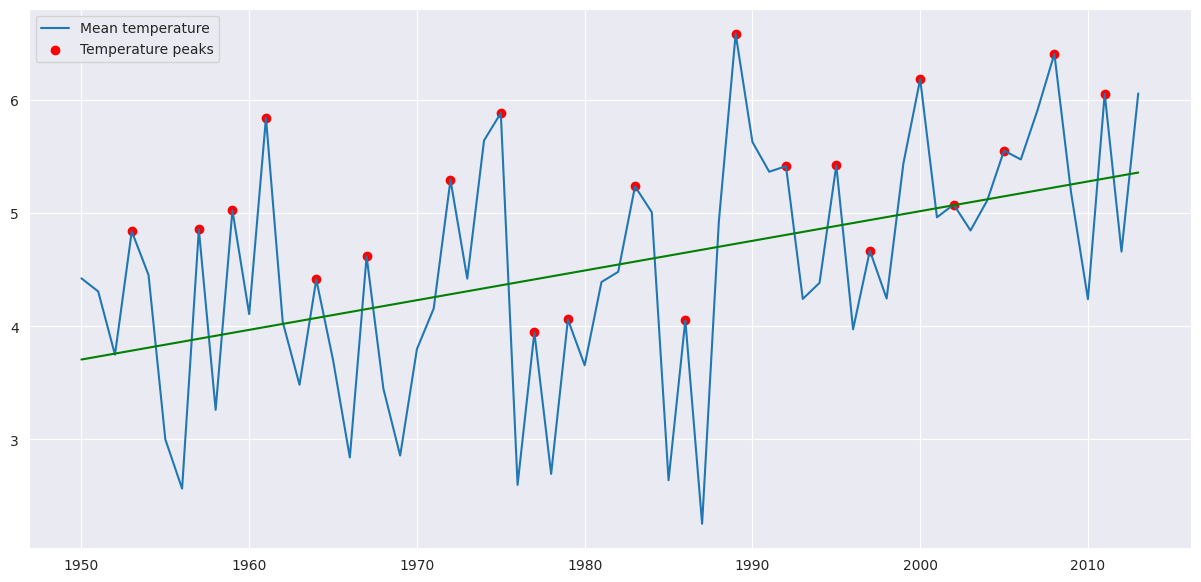

In [6]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

spb_data = df.loc[df["City"] == "Saint Petersburg"].copy()
spb_mean = spb_data.groupby(spb_data['dt'].dt.year)['AverageTemperature'].mean()
temp_peaks = spb_mean[spb_mean > spb_mean.shift(1)][spb_mean > spb_mean.shift(-1)]

plt.figure(figsize=(15, 7))
plt.plot(spb_mean.index, spb_mean.values, label="Mean temperature")
plt.scatter(temp_peaks.index, temp_peaks, color="r", label="Temperature peaks")
plt.legend()

# Reshape for LinearRegression
X = np.array(spb_mean.index).reshape(-1,1)
y = spb_mean.values.reshape(-1, 1)
reg_model = LinearRegression()
reg_model.fit(X, y)
plt.plot(spb_mean.index, reg_model.predict(X), color='g', label="Linear regression")
# Ура, глобальное потепление!

# Задание 3.6 (4 балла)

Найдите города, для которых: 
1. Разница между максимальным и минимальным значением среднегодовой температуры в выборке максимальна.
2. Самая большая средняя разница между средней температурой января и средней температурой июля.
3. Наибольшее среднее количество месяцев с отрицательной температурой в году.

In [7]:
# Разница между максимальным и минимальным значением среднегодовой температуры в выборке максимальна.
yearly_pivot_table = df.pivot_table(values='AverageTemperature', index=df.dt.dt.year, columns='City', aggfunc='mean')
# Mean by year
# (dt\City) Abidjan      Addis
# 1950      26.195417    17.080167
# 1951      26.324750    17.397167

max_min_dif = abs(yearly_pivot_table.max() - yearly_pivot_table.min())
print(f'City: {max_min_dif.idxmax()}, max min-max diff: {max_min_dif.max()}')

City: Mashhad, max min-max diff: 5.250000000000002


In [8]:
# Самая большая средняя разница между средней температурой января и средней температурой июля.
monthly_pivot_table = df.pivot_table(values='AverageTemperature', index=['City', df.dt.dt.year], columns=df.dt.dt.month, aggfunc='mean')
# Mean by month
#            dt 1       2       3       4       5       6       7       8
# City    dt
# Abidjan 1950  26.773  27.527  28.344  27.830  26.896  25.454  24.878  23.734
#         1951  26.944  27.118  27.983  27.914  26.690  25.618  24.783  24.058
# ...              ...     ...     ...     ...     ...     ...     ...     ...
# Xian    2009  -1.516   4.333   8.216  14.223  17.735  24.563  25.500  22.429
#         2010  -0.237   2.581   6.969  11.377  18.365  23.357  25.722  23.434
jan_jul_dif = abs(monthly_pivot_table[1] - monthly_pivot_table[7])
mean_jan_jul_dif = jan_jul_dif.groupby(level='City').mean()
print(f'City: {mean_jan_jul_dif.idxmax()}, max mean july-jan diff: {mean_jan_jul_dif.max()}')

City: Harbin, max mean july-jan diff: 41.99271875


In [9]:
# Наибольшее среднее количество месяцев с отрицательной температурой в году.
# Используем ту же самую таблицу, что и в предыдущем задании, меняются только манипуляции
months_with_negative_temp = monthly_pivot_table.lt(0).sum(axis=1)
avg_months_with_negative_temp = months_with_negative_temp.groupby(level='City').mean()
print(f'City: {avg_months_with_negative_temp.idxmax()}, max mean negative temp months: {avg_months_with_negative_temp.max()}')

City: Harbin, max mean negative temp months: 4.90625


# Задание 3.7 (3 балла)

Отобразите города на карте, например с помощью [geopandas/folium](https://geopandas.org/en/stable/gallery/plotting_with_folium.html) или [plotly](https://plotly.com/python-api-reference/generated/plotly.express.scatter_geo.html). Причем цвет метки должен соответствовать средней температуре в январе за последние 10 лет. 


**\***(+3 балла). Вычислите прямую с "трендом" по изменению средней температуры за год в каждом городе в период 1950-2013 (можно с помощью линейной регрессии, как в задании **3.5**). Отобразите города цветом, который зависит от угла наклона этой прямой. 


**\***(+1 балл) В дополнение к предыдущему пункту, используйте библиотеку [pwlf](https://pypi.org/project/pwlf/) с фиксированным числом сегментов и визуализируйте угол наклона последнего сегмента. 

In [10]:
import geopandas
import folium

gdf = df[(df.dt.dt.year > 2003) & (df.dt.dt.month == 1)].copy()
gdf.loc[:, "Latitude"] = gdf.Latitude.apply(lambda x: -float(x.strip('S')) if x.endswith('S') else float(x.strip('N')))
gdf.loc[:, "Longitude"] = gdf.Longitude.apply(lambda x: -float(x.strip('W')) if x.endswith('W') else float(x.strip('E')))
gb = gdf.groupby(["City", "Country", "Latitude", "Longitude"]).mean().reset_index().loc(axis=1)["City", "Latitude", "Longitude", "AverageTemperature"]

geometry = geopandas.points_from_xy(gb.Longitude, gb.Latitude)
geo_df = geopandas.GeoDataFrame(
    gb[["City", "Latitude", "Longitude", "AverageTemperature"]], geometry=geometry
)

def calc_degree(city_data):
    data = city_data.groupby(city_data['dt'].dt.year)['AverageTemperature'].mean()
    X = np.array(data.index).reshape(-1,1)
    y = data.values.reshape(-1, 1)
    reg_model = LinearRegression()
    reg_model.fit(X, y)
    degree = np.arctan(1 + reg_model.coef_[0][0]/reg_model.intercept_[0])*180/np.pi
    return degree

def get_color(value, tmin, tmax):
    h = (1 - (value+abs(tmin))/(abs(tmin)+abs(tmax)))* 240
    return "hsl(" + str(h) + ", 100%, 50%)"

def get_color_from_trend(degree, tmin, tmax):
    x = (degree-tmin)/(tmax-tmin)
    h = (1 - x)* 240
    return "hsl(" + str(h) + ", 100%, 50%)"

geo_df["Degree"] = geo_df.City.apply(lambda x: calc_degree(df.loc[df.City == x]))

folium_map = folium.Map(location=[60.27, 29.19], tiles="CartoDB Positron", zoom_start=9)
for index, row in geo_df.iterrows():
    color = get_color(row.AverageTemperature, geo_df.AverageTemperature.min(), geo_df.AverageTemperature.max())
    trend_color = get_color_from_trend(row.Degree, geo_df.Degree.min(), geo_df.Degree.max())

    folium_map.add_child(
        folium.Marker(
            location=[row.geometry.y, row.geometry.x],
            popup=str(row.City) + ' ' + str(row.AverageTemperature),
            icon=folium.Icon(color='black', icon_color=color),
        )
    )

folium_map

# *Задание 3.8 (8 баллов)

Цель - создать проект, который как минимум включает:
1. Использование юнит-тестов ([pytest](https://pytest.org)).
2. Применение средств форматирования и проверки исходного кода (например: [isort](https://pycqa.github.io/isort/), [black](https://black.readthedocs.io/en/stable/), [flake8](https://flake8.pycqa.org/en/latest/), [mypy](https://mypy.readthedocs.io/en/stable/)).
3. Спецификацию проекта в [pyproject.toml](https://pip.pypa.io/en/stable/reference/build-system/pyproject-toml/).
4. Использование утилит для работы с командной строкой ([argparse](https://docs.python.org/3/library/argparse.html), [click](https://click.palletsprojects.com/en/8.1.x/) и т.п.)
5. Сборку проекта в Wheel-файл.

Проект должен быть загружен в репозиторий. Функционал - произвольный, но должны использоваться данные из этого домашнего задания. Сам файл передается в качестве первого аргумента командной строки.  Например:

> python3 -m homeproject.app GlobalLandTemperaturesByMajorCity.csv 1980

Выдает самый жаркий месяц и город по наблюдениям за 1980 год.

*Ссылка на проект* =(